In [100]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import jax
import jax.numpy as jnp

import numpyro

import latento

import latenta

# this is a biological package for plotting single-cell data
import scanpy as sc

# we use this package for some helper functions for plotting
import scpyro

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# set this to gpu if you get it to work
numpyro.set_platform('cpu')

# test gpu
key = jax.random.PRNGKey(0)

In [102]:
# the structure of the toy dataset
config = {
    "id":"toy",
    "n_cells":400,
    "modules":[
        {"id":"add_uniform_perturbation"}, # adds a perturbation to each cell
        {"id":"add_perturbation_switch"}, # adds a switch somewhere along the perturbation
        {"id":"add_nothing", "n":10}, # adds n genes that stay the same in all cells
        {"id":"add_perturbed_linear", "n":10}, # adds n genes of which the expression changes linearly with the perturbation
        {"id":"add_perturbed_switch", "n":10} # adds n genes of which the expression changes at the switch point
    ]
}

In [103]:
# creates the toy
toy = latenta.toy.wrap.cases.get_case(config)

# sample the data (i.e. negative binomial)
latenta.toy.sample.sample(toy)

# create a dataset out of this
dataset = latenta.toy.wrap.wrap_model(toy)

# create a "latento" dataset (=numpyro) instead of a "latenta" (=pyro) one
dataset = latento.dataset.PerturbedDataset.from_latenta(dataset)

In [118]:
# dataset.obs contains info on cells
dataset.obs.head(5)

,cell_ix,cell,library,x_perturb,x_perturb_log
cell,,,,,
cell_0,0,cell_0,150,0.0,0.0
cell_1,1,cell_1,150,0.0,0.0
cell_2,2,cell_2,150,0.0,0.0
cell_3,3,cell_3,150,0.0,0.0
cell_4,4,cell_4,150,0.0,0.0


In [117]:
# dataset.var contains info on genes
dataset.var.head(5)

,gene,gene_ix,type,dispersion,structure_id,extra,symbol
gene,,,,,,,
nothing_1,nothing_1,0,nothing,0.5,NaN,{'rho_0': 41.7022004702574},nothing_1
nothing_2,nothing_2,1,nothing,0.5,NaN,{'rho_0': 43.59949021420037},nothing_2
nothing_3,nothing_3,2,nothing,0.5,NaN,{'rho_0': 55.07979025745755},nothing_3
nothing_4,nothing_4,3,nothing,0.5,NaN,{'rho_0': 96.70298390136767},nothing_4
nothing_5,nothing_5,4,nothing,0.5,NaN,{'rho_0': 22.199317108973947},nothing_5


In [119]:
# dataset.counts contains the raw counts
dataset.counts

gene,nothing_1,nothing_2,nothing_3,nothing_4,nothing_5,nothing_6,nothing_7,nothing_8,nothing_9,nothing_10,...,switch_down_21,switch_down_22,switch_up_23,switch_down_24,switch_down_25,switch_up_26,switch_down_27,switch_down_28,switch_up_29,switch_up_30
cell,,,,,,,,,,,,,,,,,,,,,
cell_0,15.0,0.0,2.0,1.0,0.0,12.0,0.0,25.0,0.0,14.0,...,4.0,5.0,0.0,5.0,21.0,0.0,14.0,42.0,0.0,0.0
cell_1,10.0,3.0,4.0,32.0,7.0,29.0,4.0,17.0,1.0,15.0,...,0.0,11.0,0.0,3.0,4.0,0.0,4.0,7.0,0.0,0.0
cell_2,11.0,9.0,9.0,11.0,0.0,15.0,0.0,33.0,0.0,27.0,...,9.0,2.0,1.0,6.0,0.0,0.0,5.0,19.0,0.0,0.0
cell_3,5.0,7.0,3.0,31.0,1.0,7.0,0.0,0.0,0.0,7.0,...,8.0,7.0,0.0,25.0,9.0,1.0,11.0,8.0,0.0,0.0
cell_4,7.0,6.0,2.0,4.0,5.0,7.0,0.0,12.0,0.0,41.0,...,14.0,2.0,0.0,0.0,0.0,0.0,19.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_395,7.0,17.0,0.0,8.0,1.0,6.0,3.0,45.0,0.0,11.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,3.0
cell_396,8.0,19.0,2.0,6.0,4.0,18.0,2.0,10.0,0.0,0.0,...,1.0,6.0,1.0,17.0,3.0,0.0,3.0,7.0,1.0,1.0
cell_397,2.0,2.0,7.0,5.0,4.0,13.0,0.0,26.0,0.0,3.0,...,3.0,5.0,0.0,11.0,8.0,0.0,6.0,10.0,0.0,0.0


In [123]:
# dataset.perturb.X contains the counts of the perturbation
# in this dataset there is only one perturbation present
# mose cells are not perturbed (i.e. control cells)
dataset.perturb.X

perturb_id,x
cell,
cell_0,0.000000
cell_1,0.000000
cell_2,0.000000
cell_3,0.000000
cell_4,0.000000
...,...
cell_395,133.907328
cell_396,8.719618
cell_397,11.724952


In [129]:
# choose some genes for plotting, each with a different "type"
gene_ids = dataset.var.groupby("type").sample(n=1, random_state=3)["gene"]

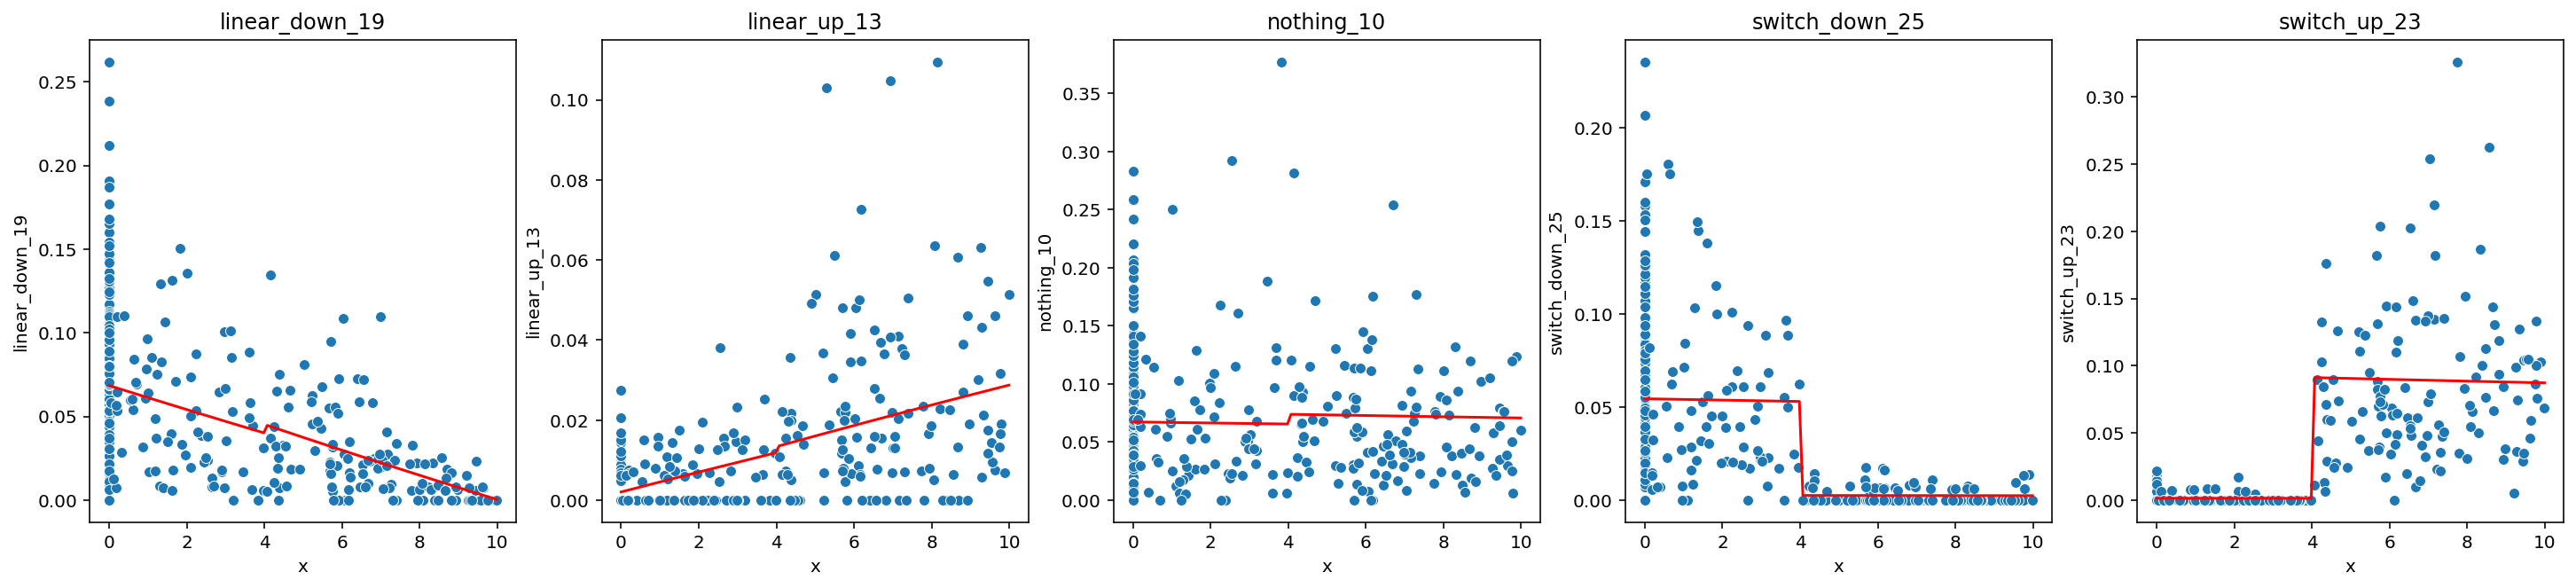

In [130]:
# let's plot some genes
# biologists are not interested in the number of counts in a cell, but rather it's normalized value: the percentage of counts in a cell that comes from a certain gene
# we give this value the greek symrbol "rho"
# because we're currently using synthetic data, we know the ground truth rho
# what we observe is a very noise value of this for each cell and gene

# select a couple of genes of interest, for each "type"
perturb_id = toy.perturb.var.index[0]

fig, axes = scpyro.plotting.axes_wrap(len(genes))
for gene, ax in zip(gene_ids, axes):
    x = np.log(dataset.perturb.X[perturb_id] + 1)
    sns.scatterplot(x = x, y = dataset.rho[gene], ax = ax)
    sns.lineplot(x = x, y = dataset["rho"][gene], ax = ax, color = "red") # gold standard rho
    ax.set_title(gene)

<AxesSubplot:xlabel='gene', ylabel='cell'>

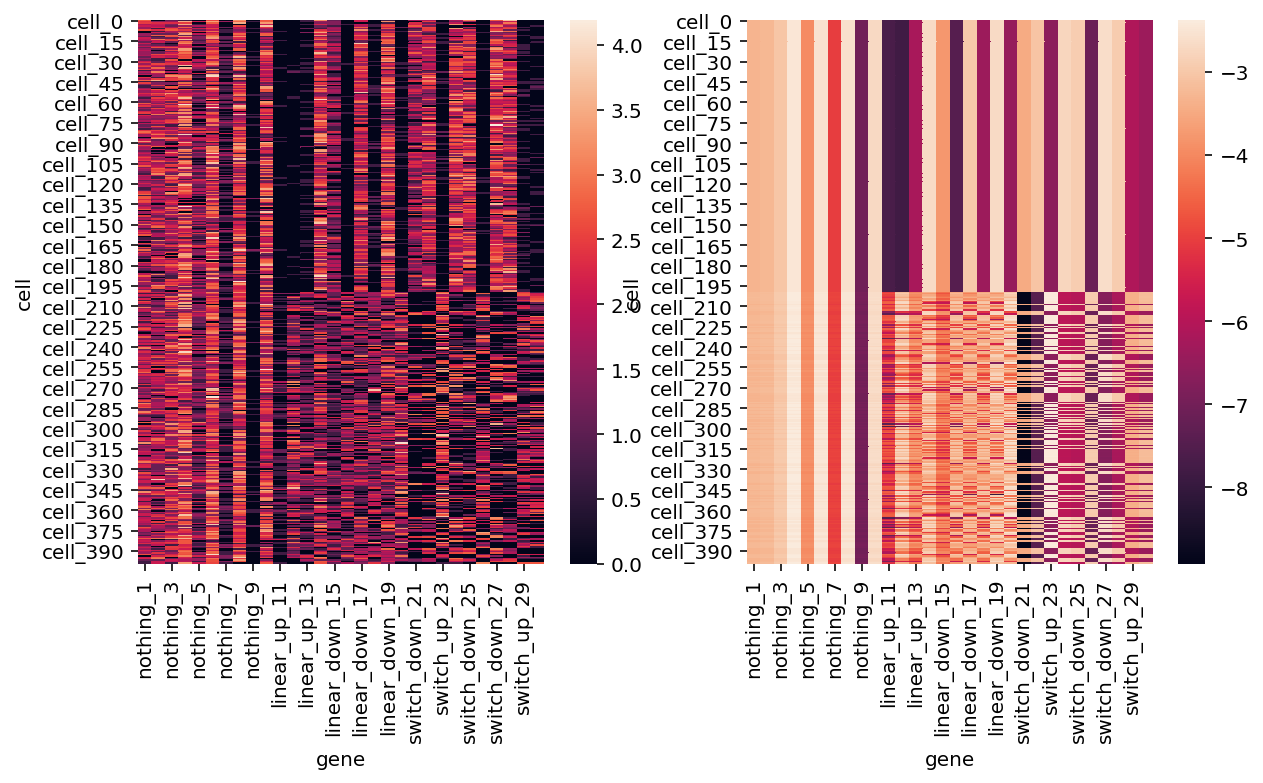

In [131]:
# this is how the gene expression looks like: cells vs genes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
sns.heatmap(np.log(dataset.counts + 1), ax = ax1) # this is the gene expression as we observe it, i.e. counts. For visualization we often calculate a log(x+1)
sns.heatmap(np.log(dataset["rho"]), ax = ax2) # this is the gold standard "rho" = the fraction that comes from a certain gene. This is what we're mainly interested in

/home/wouters/software/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/home/wouters/software/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


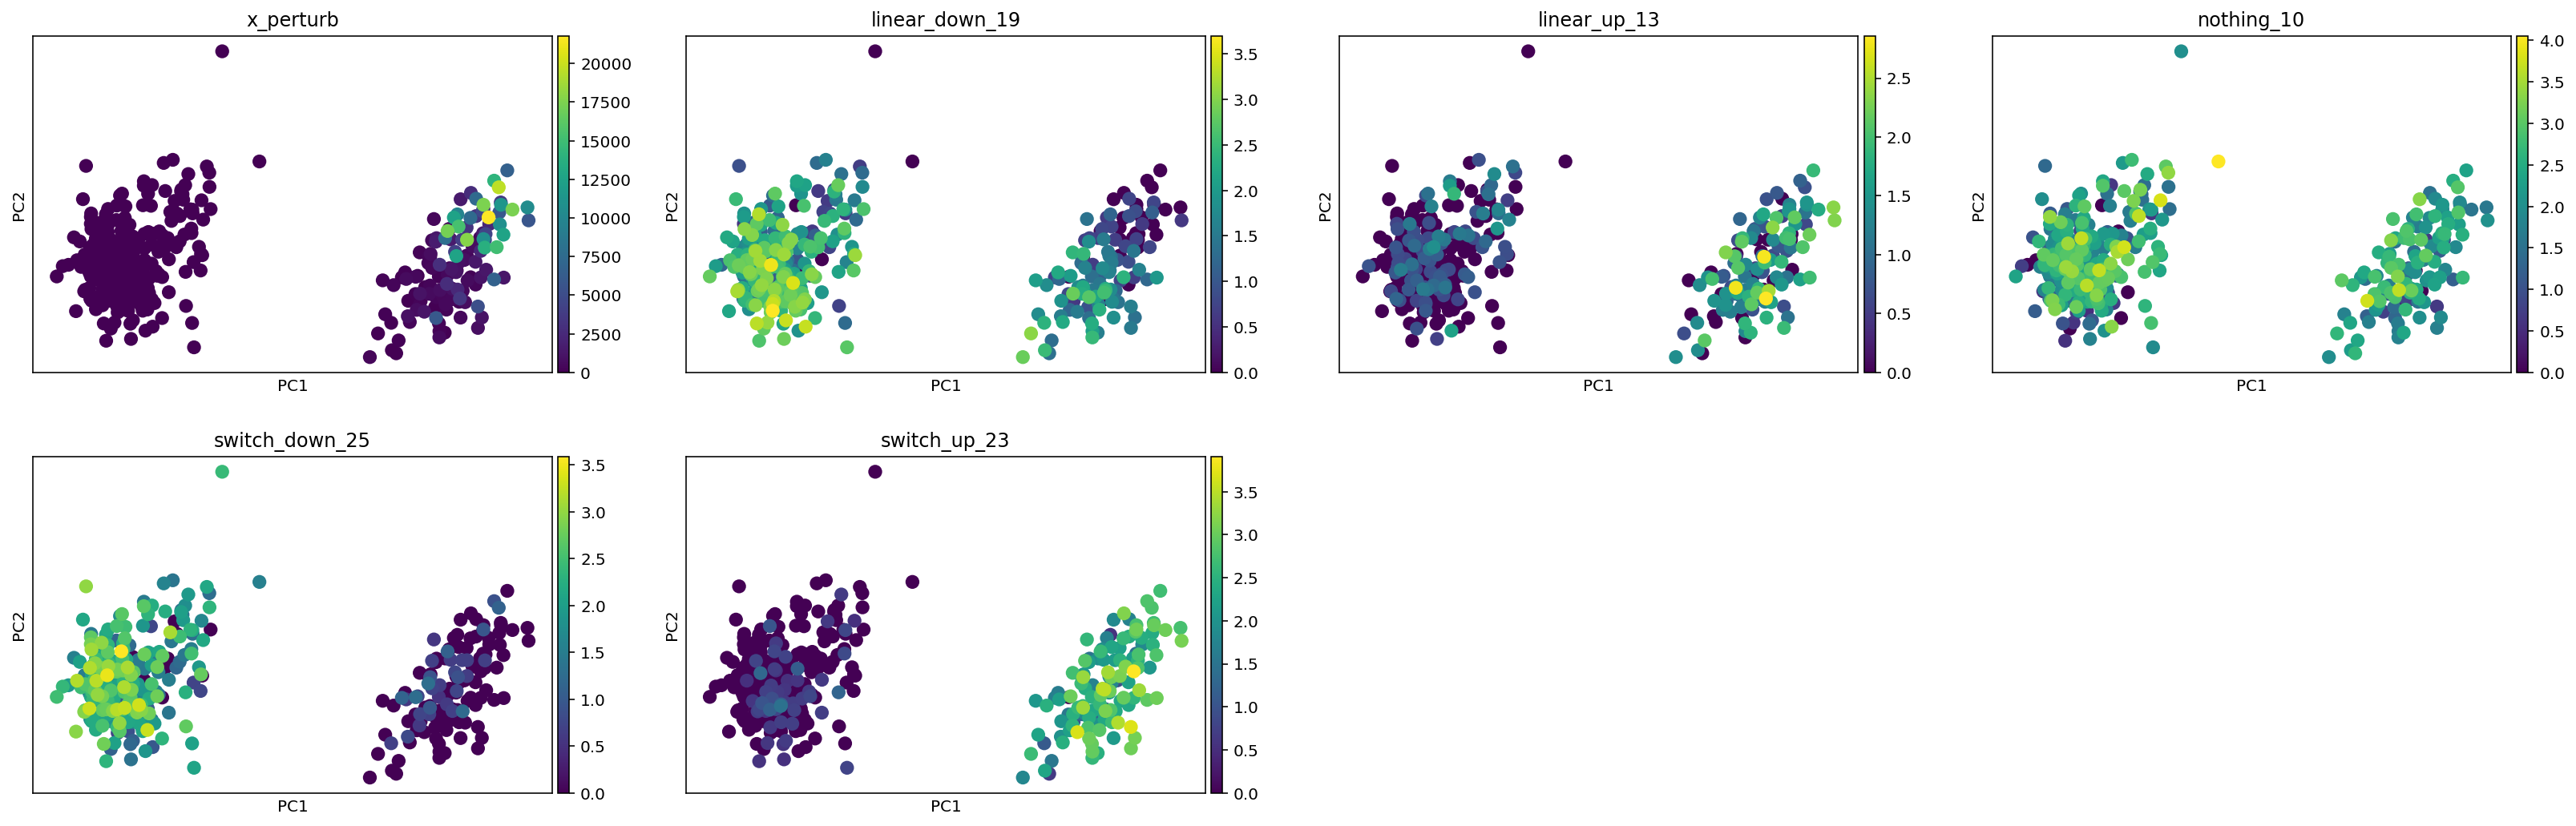

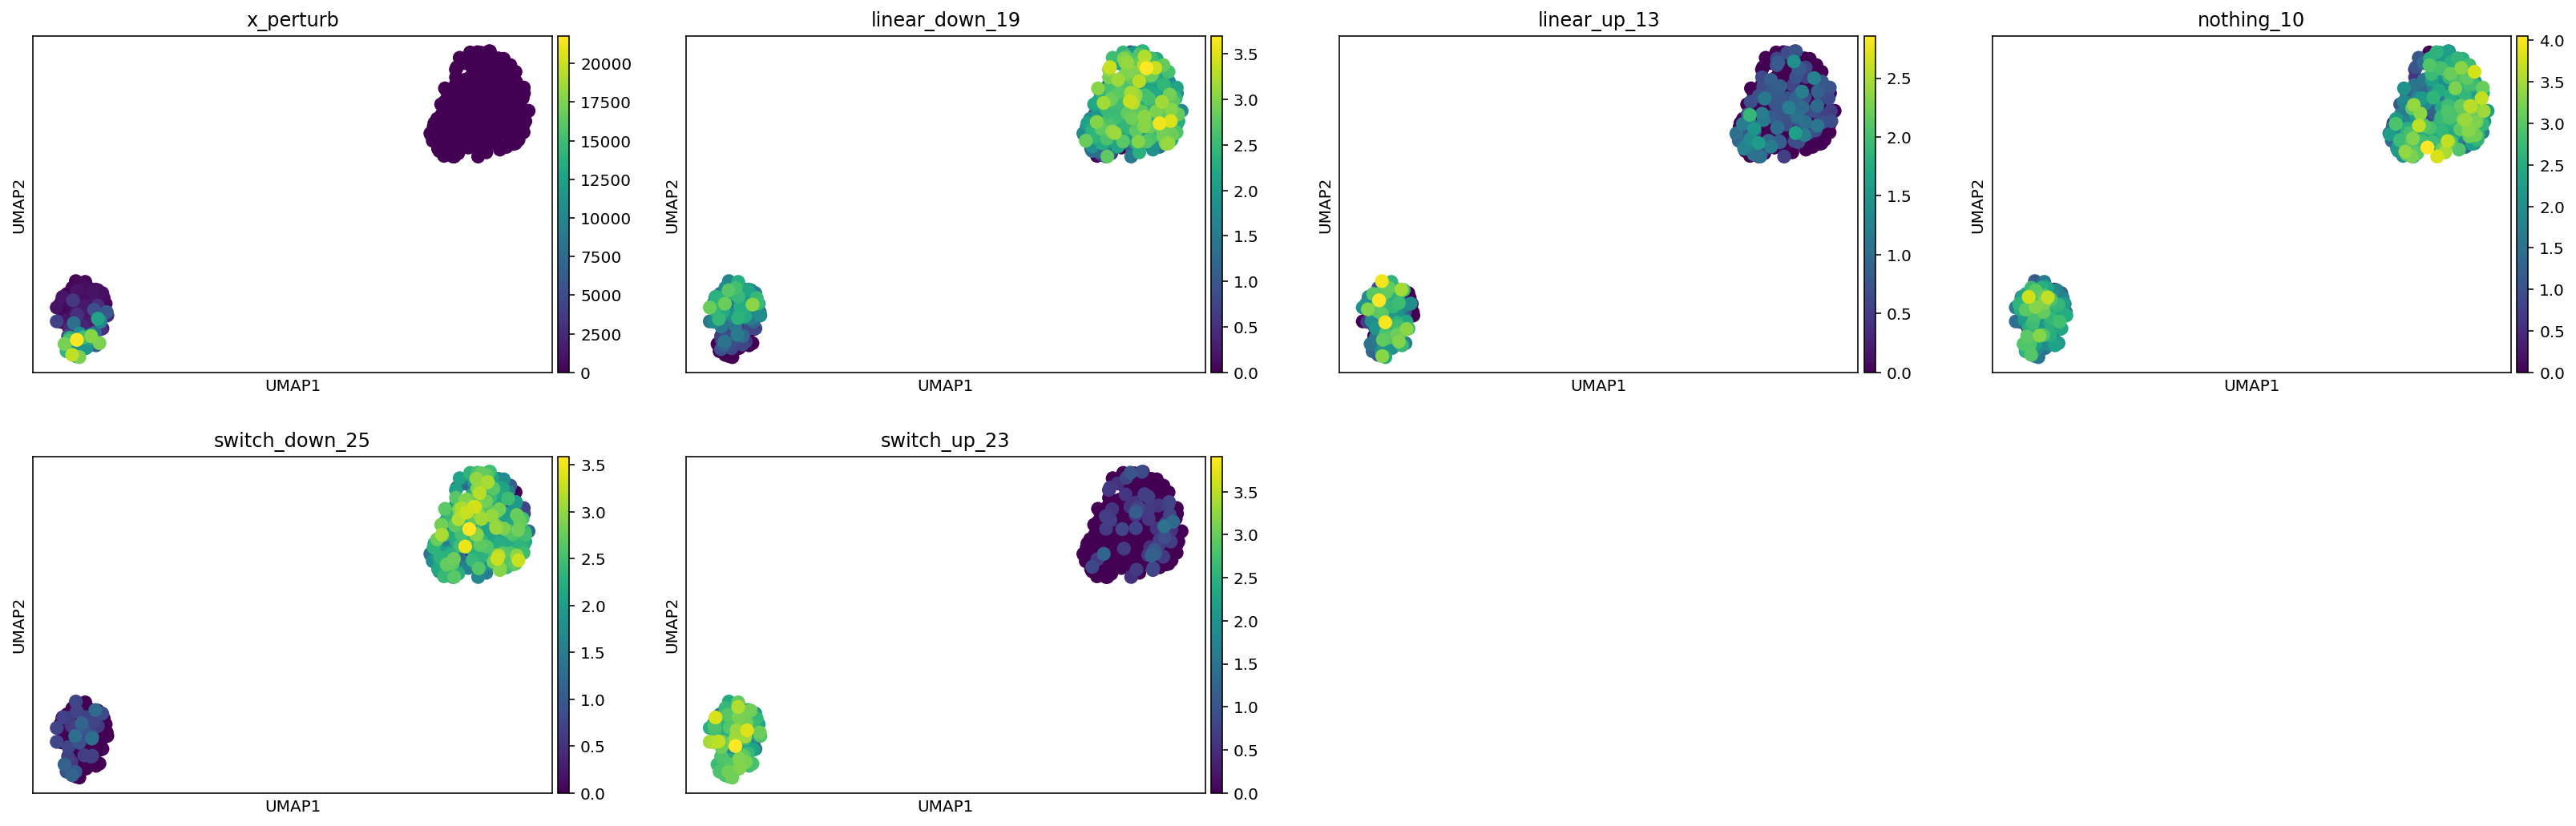

In [136]:
# single-cell data is often plotted on a pca or umap (non-linear dimensionality reduction)
# we can then plot the perturbation (x_perturb) or the gene expression (e.g. linear_down_19) on this (again often log(x+1) transformed)
# we'll use the scanpy package for this plotting
# you can access this dimensionality reduction using dataset.adata.obsm["X_pca"] or dataset.adata.obsm["X_umap"]
sc.tl.umap(dataset.adata)
sc.pl.pca(dataset.adata, color = ["x_perturb"] + gene_ids.tolist()) # pca
sc.pl.umap(dataset.adata, color = ["x_perturb"] + gene_ids.tolist()) # umap

In [137]:
# define our model
# check out latento/models.py for explanation!!

model = latento.models.ModelNothing(dataset)

# model = latento.models.ModelLinear(dataset)

In [138]:
# we don't use the raw perturbation values, but use log (x + 1) transformed ones
p = np.log(dataset.perturb.X["x"].values + 1)

# we also scale the perturbation values between 0 and 1
p = p / p.max()

# these are the arguments that the inference functions need
infer_args = {"p":p, "Y":dataset.get_Y(), "library":dataset.get_library()}

**Your tasks**

Implement a "switch"-like model, i.e. where the gene expression jumps up or down (=beta) at a particular perturbation value (=switch). 

Because this function is not smooth at p = switch, it can be hard to train using gradient-based optimizers. We therefore approximate the switch model using a "relaxation"* : deviation = beta * (1/(1 + e**(-skew * (p - switch)). beta and switch are random variables, skew is a fixed value that we choose ourselves and defines the extent of "relaxation", I often choose 50

If there is time left, you can try to implement other models, e.g. an exponential model, or a spline model. But only if there is time left!

*: https://en.wikipedia.org/wiki/Relaxation_(approximation)

## Training-test split

In [140]:
training_frac = 0.5

training_size = int(np.round(dataset.obs.shape[0] * training_frac))
training_cells = np.random.choice(dataset.obs.index, training_size, replace = False)
test_cells = [cell for cell in dataset.obs.index if cell not in training_cells]

dataset_training = dataset.select_cells(training_cells)
dataset_test = dataset.select_cells(test_cells)

**Your tasks**

In the code that follows, I used the full dataset for training and validation. This is wrong, especially once you will start comparing models. Your task is to split this up. Code for getting a training and test dataset is already provided above

## MCMC

MCMC sampling using a NUTS sampler

A nice explanation on how MCMC (and sampling in general) allows you to get an "exact" posterior: https://bjlkeng.github.io/posts/markov-chain-monte-carlo-mcmc-and-the-metropolis-hastings-algorithm/

In [141]:
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

# you may have to adjust some of these parameters if the NUTS samplers doesn't converge during warmup
# you can see this with e.g. the r_hat values
num_warmup, num_samples = 1000, 2000

# Run NUTS
kernel = numpyro.infer.NUTS(model.forward)
mcmc = numpyro.infer.MCMC(kernel, num_warmup, num_samples)

mcmc.run(rng_key_, **infer_args)

sample: 100%|██████████| 3000/3000 [00:33<00:00, 90.10it/s, 7 steps of size 4.56e-01. acc. prob=0.88]  


In [142]:
# some statistics of the posterior, the r_hat is a statistic of "convergence" for a particular random variable, this should be close to 1
mcmc.print_summary()


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 transcriptome/dispersion[0]      2.40      0.25      2.38      2.00      2.80   2386.67      1.00
 transcriptome/dispersion[1]      1.79      0.17      1.78      1.53      2.08   2496.61      1.00
 transcriptome/dispersion[2]      2.08      0.19      2.07      1.76      2.38   3433.81      1.00
 transcriptome/dispersion[3]      1.86      0.15      1.85      1.62      2.10   3355.62      1.00
 transcriptome/dispersion[4]      1.80      0.21      1.78      1.47      2.14   2272.40      1.00
 transcriptome/dispersion[5]      2.27      0.19      2.26      1.94      2.57   2326.73      1.00
 transcriptome/dispersion[6]      1.49      0.27      1.46      1.09      1.94   1646.55      1.00
 transcriptome/dispersion[7]      2.06      0.17      2.06      1.80      2.35   2935.06      1.00
 transcriptome/dispersion[8]      0.72      0.29      0.67      0.29      1.09   1730.43      1.00
 transcri

In [143]:
# get the samples from the posterior
model.eval = True
samples_mcmc = mcmc.get_samples()

## Black-box variational inference

In variational inference we approximate the posterior using a variational distribution

As wikipedia explains (https://www.wikiwand.com/en/Variational_Bayesian_methods):

> For many applications, variational Bayes produces solutions of comparable accuracy to Gibbs sampling at greater speed. However, deriving the set of equations used to update the parameters iteratively often requires a large amount of work compared with deriving the comparable Gibbs sampling equations. This is the case even for many models that are conceptually quite simple, as is demonstrated below in the case of a basic non-hierarchical model with only two parameters and no latent variables.

BUT, in black-box variational inference, this "set of equations used to update the paramters" is derived computationally using automatic differentiation (i.e. using autograd or jax). This is implemented in numpyro (or pyro). Check out this talk for an explanation by the inventor himself: https://www.youtube.com/watch?v=-H2N4tVDK7I

However, this does not mean that our approximation of the posterior is good. Often the variance is underestimated, but the mean of the posterior can also be off. This is really bad as it can lead to wrong biological conclusions. See this talk: https://www.youtube.com/watch?v=Moo4-KR5qNg

In [144]:
# we again want to do inference, so set eval off
model.eval = False

In [145]:
import numpyro.infer.autoguide
import tqdm.auto as tqdm

In [146]:
# we define our variational distribution or "guide"
# we will use the variational distribution to approximate the actual posterior as much as possible
# this is often a simple distribution from which it is easy to sample, in this case an autodiagonal normal
# note that this diagonalnormal distribution is also often called the "mean-field" approximation
# for each random variable, this distribution has two sets of parameters: a mean and a variance
# note that this distribution assumes no relationships between the posteriors of any variables! (i.e. covariance = 0)
# it may be possible that this assumption is not correct for some models, genes or variables
# if that is the case, you could try to use another variational distribution, e.g.:
# - to fully model dependencies between variables, you can use a AutoMultivariateNormal, that will model the full covariance matrix using a cholensky decomposition
# - to model some dependencies you can use a AutoLowRankMultivariateNormal, this will model a low-rank version of the full covariance matrix again using a cholensky decomposition
# in any case, these alternative guides are still approximations, i.e. we still only use a normal distribution!
# it may be that the actual posterior has heavy tails or multiple modes, things that we cannot model with just a normal distribution

# important to note: for variables that do not have a real support (e.g. unit interval, all positive numbers, ...) the samples are transformed after they are sampled from the normal distribution (which as you know has real support)
# for example, the dispersion is only defined for positive numbers (we use a lognormal distribution), so after sampling x from the normal distribution, the guide will take e^x as the value of the dispersion
# similarly, for the freq, thgis is only defined in ]0, 1[, so the guide will take the logit
# this is all done under the hood for you by the autoguide function, base on the support of the prior distribution
guide = numpyro.infer.autoguide.AutoDiagonalNormal(model.forward, init_loc_fn=numpyro.infer.init_to_feasible)

# we use ADAM for optimization
optim = numpyro.optim.Adam(step_size = 0.01)

# our loss function is the ELBO, which is an approximation (=lower bound) to the actual KL divergence between the guide and the "real" posterior
# you can find several derivations of this on the internet:
# - https://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/
# - https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/
loss = numpyro.infer.Trace_ELBO()

In [147]:
# number of iterations
n_iterations = 1000

# we will do stochastic variational inference: stochastic because we sample from the prior and posterior (=guide) at each iteration
svi = numpyro.infer.svi.SVI(model.forward, guide, optim, loss)

# define the initial state
current_state = svi.init(rng_key, **infer_args)

# keep track of the losses
losses = []
progress = tqdm.tqdm(range(n_iterations))
for i in progress:
    # take one step
    current_state, current_loss = svi.update(current_state, **infer_args)
    losses.append(current_loss.item())
    
    progress.set_description(str(round(current_loss.item(), 2)))

<AxesSubplot:>

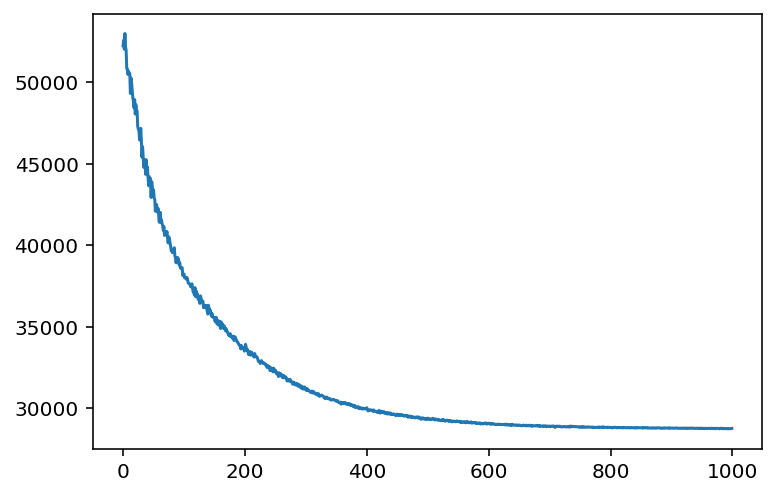

In [148]:
sns.lineplot(x = range(len(losses)), y = losses)

In [149]:
# let's get samples from this posterior, in the same format as the samples from the mcmc posterior
model.eval = True

parameters = svi.get_params(current_state) # make sure that you understand what these parameters of the posterior mean (no pun intended)

n_samples = 1000
samples_vi_raw = []

for i in range(n_samples):
    rng_key = jax.random.PRNGKey(i)
    samples_vi_raw.append(guide.sample_posterior(rng_key, parameters))
    
samples_vi = {}
for site_id in samples_vi_raw[0].keys():
    samples_vi[site_id] = jnp.stack([samples_vi_raw[i][site_id] for i in range(len(samples_vi_raw))])

## Compare MCMC and VI

### Comparing posterior distributions of individual or pairs of parameters

In [150]:
# choose a gene
gene_ix = 14

# choose some samples, e.g. the dispersion and the 
samples_mcmc_1 = samples_mcmc["transcriptome/dispersion"][:, gene_ix]
samples_vi_1 = samples_vi["transcriptome/dispersion"][:, gene_ix]

samples_mcmc_2 = samples_mcmc["transcriptome/freq"][:, gene_ix]
samples_vi_2 = samples_vi["transcriptome/freq"][:, gene_ix]

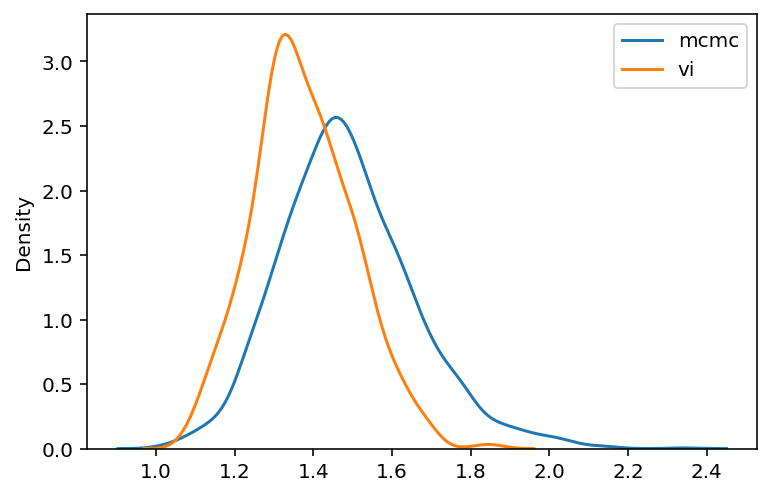

In [151]:
# compare a single variable
sns.kdeplot(samples_mcmc_1, label = "mcmc")
sns.kdeplot(samples_vi_1, label = "vi")
plt.legend()

/home/wouters/software/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/wouters/software/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


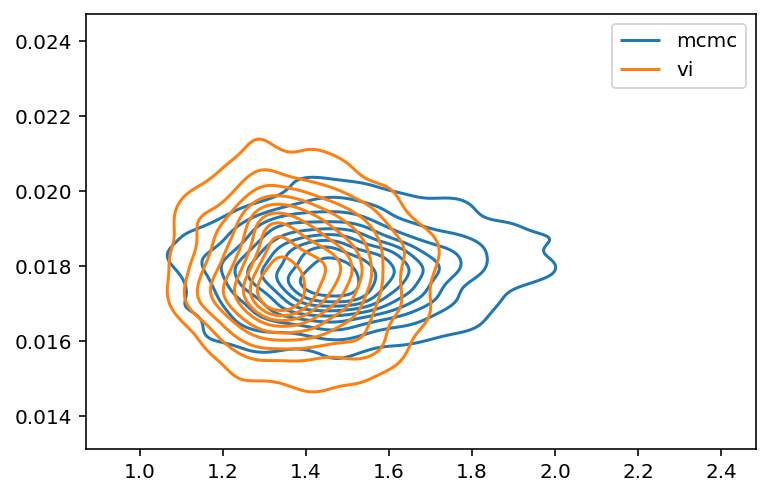

In [152]:
# compare two variables, e.g. to check dependencies
sns.kdeplot(samples_mcmc_1, samples_mcmc_2, label = "mcmc")
sns.kdeplot(samples_vi_1, samples_vi_2, label = "vi")
plt.legend()

**Your task**

- How does the "exact" posterior look like?
- Does VI provide a good approximation of the mean?
- Does VI provide a good approximation of the variance?
- Does the posterior has any weird features, such as multiple modes or long tails?
- Are there any dependencies within the posterior?

All of these questions you can answer for:

- Is this variable dependent? E.g. dispersion vs beta...
- Is this model dependent? E.g. the "nothing" vs "linear" model...
- Is this gene dependent? E.g. "nothing" genes vs "linear" genes..., check out `dataset.var["type"]` to get the type of a gene

### Comparing models

In [153]:
model.eval = True

# to check out our model, we will see how gene expression depends on the perturbation
# e.g. if a perturbation is 1, what is the gene expression?
# we do not care about the library so we just fix it to 100
design = {
    "p":jnp.linspace(0, 1, 50),
    "library":jnp.array([100] * 50)
}

In [154]:
# we give these p and library values to the models and check what the "rho" value is, this is the value we are actually interested in
predictive_mcmc = numpyro.infer.Predictive(model.forward, samples_mcmc, return_sites = ["rho"])
predictions_mcmc = predictive_mcmc(rng_key_, **design)

predictive_vi = numpyro.infer.Predictive(model.forward, samples_vi, return_sites = ["rho"])
predictions_vi = predictive_vi(rng_key_, **design)

In [156]:
# which genes do we want to plot
gene_ixs = dataset.feature_ix(gene_ids).tolist()

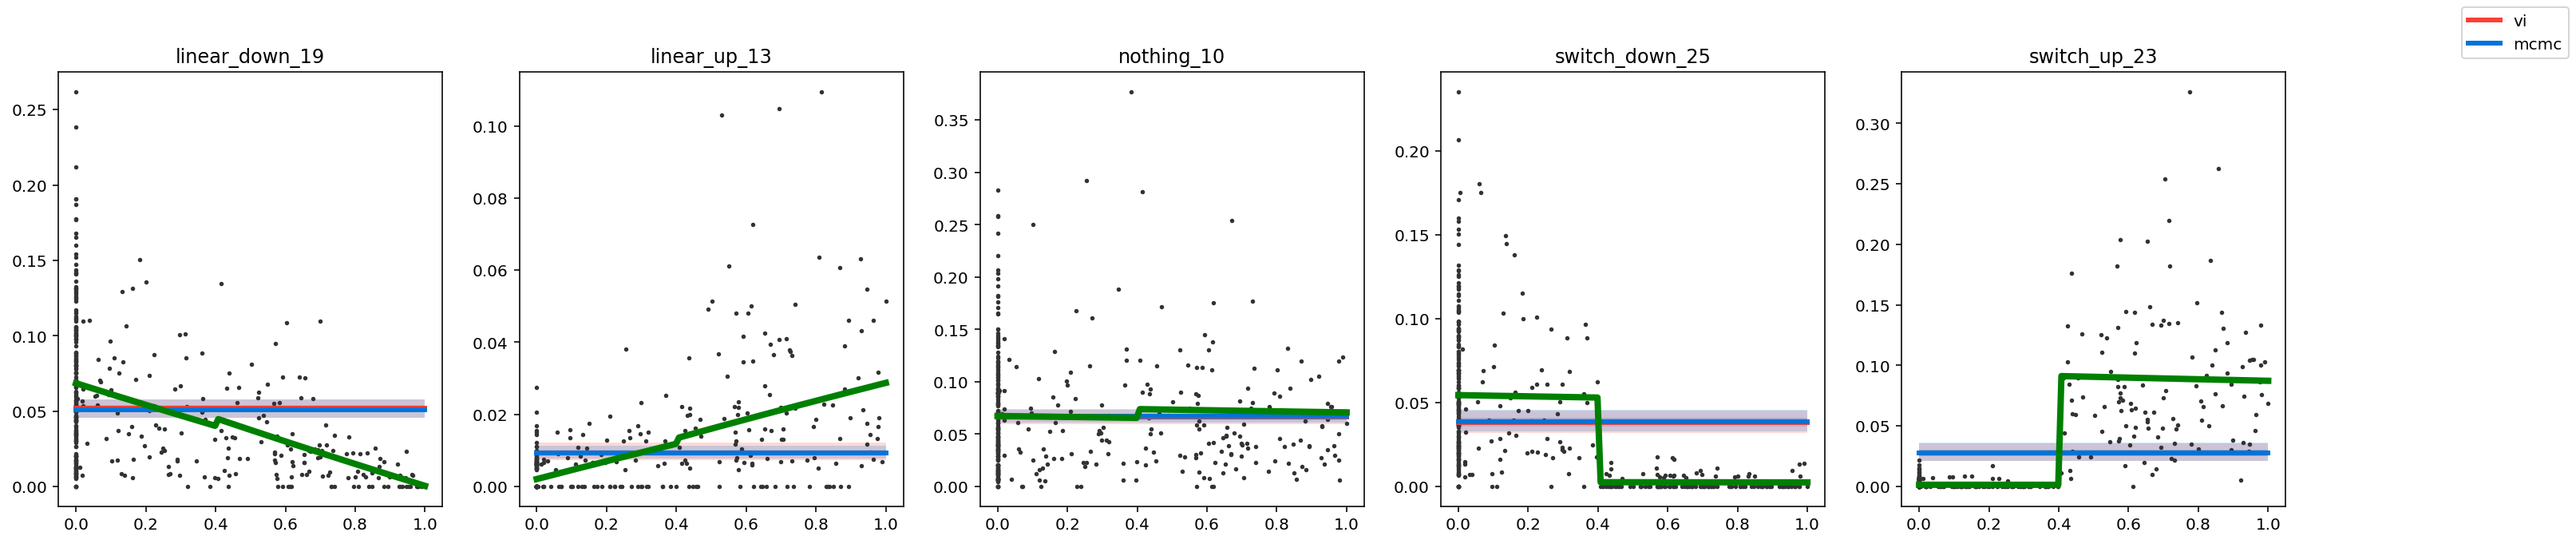

In [157]:
# plot the models for the genes
x = design["p"]
Ys = {"vi":predictions_vi["rho"], "mcmc":predictions_mcmc["rho"]}
model_colors = {"vi":"#FF4136", "mcmc":"#0074D9"}

# empirical values
x_empirical = infer_args["p"]
Y_empirical = dataset.rho.values

# gold standard values (we have these because this is toy data)
x_gs = infer_args["p"]
Y_gs = dataset["rho"].values

rho = dataset

fig, axes = scpyro.plotting.axes_wrap(len(gene_ixs))

legend_artists = {}
for gene_ix, ax in zip(gene_ixs, axes):
    # plot models
    for model_id, Y in Ys.items():
        y = Y[:, :, gene_ix]
        
        color = model_colors[model_id]

        q_left = [0.99, 0.8, 0.65] # which upper quantiles to plot
        q = q_left + [0.5] + [round(1 - q, 3) for q in q_left[::-1]] # which quantiles to plot
        qy = np.quantile(y, q, 0)
        qmed = qy[len(q_left)]

        for i in range(len(q_left)):
            artist = ax.fill_between(x, qy[i], qy[-i-1], color = color, lw = 0, alpha = 0.2)
            pass
        artist = ax.plot(x, qmed, color = color, lw = 3)
        legend_artists[model_id] = artist[0]
        
    # plot empirical
    y_empirical = Y_empirical[:, gene_ix]
    ax.scatter(x_empirical, y_empirical, s = 3, color = "#333333")
    
    # plot gold standard
    y_gs = Y_gs[:, gene_ix]
    sns.lineplot(x = x_gs, y = y_gs, ax = ax, color = "green", lw = 4) # gold standard rho
    
    ax.set_title(dataset.symbol(feature_ix = gene_ix))
fig.legend(legend_artists)

To compare models (e.g. a "nothing" model vs a "linear" model), we will check their "Posterior Predictive Density", which is essentially the likelihood of the observations based on the posterior distribution.

Note that this value does not account for overfitting, and complex models will typically have a higher posterior predictive density. We therefore have to use 

In [158]:
model_conditioned = numpyro.handlers.condition(numpyro.handlers.seed(model.forward, rng_key), {})
model_trace = numpyro.handlers.trace(model_conditioned).get_trace(**infer_args)
obs_node = model_trace['transcriptome']

In [159]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model_conditioned = numpyro.handlers.condition(numpyro.handlers.seed(model, rng_key), params)
    model_trace = numpyro.handlers.trace(model_conditioned).get_trace(*args, **kwargs)
    obs_node = model_trace['transcriptome']
    return obs_node['fn'].base_dist.log_prob(obs_node['value']) # remove the event dimensions by using the base dist as we're interested in the log probability per gene

def log_pred_density(rng_key, samples, model, *args, **kwargs):
    n = list(samples.values())[0].shape[0]
    log_lk_fn = jax.vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(jax.random.split(rng_key, n), samples)
    return (jax.scipy.special.logsumexp(log_lk_vals, 0) - jnp.log(n))

In [160]:
lpd = log_pred_density(rng_key, samples_mcmc, model.forward, **infer_args)

In [165]:
lpd_gene = lpd.mean(0) # the mean log predictive density for a gene across all cells
lpd_gene

DeviceArray([-2.725937  , -2.7962787 , -2.9644647 , -3.5035512 ,
             -2.2399817 , -3.392265  , -1.4533625 , -3.3620374 ,
             -0.45817277, -3.295496  , -0.8435185 , -1.8937329 ,
             -1.588212  , -3.174781  , -2.1340961 , -1.7290673 ,
             -2.8618035 , -1.8671995 , -3.081276  , -2.1334066 ,
             -2.2426786 , -2.6731837 , -2.0725412 , -2.905181  ,
             -2.8017533 , -1.7164901 , -2.9579282 , -2.7482495 ,
             -1.8187214 , -1.7439204 ], dtype=float32)

**Your task**

- Compare the log predictive density for each gene for different models. Do they make sense? I.e. for genes that do not change with the perturbation, the lpd should be approximately the same for different models. For genes that have a linear pattern, the best model should be linear. Etc...
- Could we make some wrong conclusions if we use VI instead of getting an exact posterior using e.g. MCMC? Could we for example choose an incorrect model? Could we be overconfident?

Again...

- Is this dependent on the type of gene? (nothing, linear, switch, ...)